# Capstone 2 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pmdarima.metrics import smape # Symmetric Mean Absolute Percentage Error.
from pmdarima.arima import auto_arima
%matplotlib inline

In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
df2.head()

,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Daily
Date,,,,,,,,,,,,,,
2016-01-04,16.39,36.27,78.68,51.44,57.70,148.93,74.55,50.34,56.02,79.35,58.34,31.68,0.00,739.69
2016-01-05,22.45,27.75,7.25,30.64,100.67,149.72,43.14,68.53,93.65,75.90,27.45,31.70,0.00,678.85
2016-01-06,33.59,41.48,111.56,92.00,94.83,94.27,45.26,70.35,57.22,52.53,46.87,49.12,0.00,789.08
2016-01-07,8.40,23.30,54.49,42.28,116.13,101.65,52.04,47.96,128.00,77.01,91.02,75.42,0.00,817.70
2016-01-08,27.25,86.00,48.34,65.21,186.20,158.67,93.76,117.30,143.23,105.70,182.96,89.71,64.12,1368.45


# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

In [3]:
#train_test_split, since we only have 2 years of data, we test the last 4 months
train_start,train_end = '2016-01-04','2017-08-31'
test_start,test_end = '2017-09-01','2017-12-31'
train = df2['Daily'][train_start:train_end].dropna()
test = df2['Daily'][test_start:test_end].dropna()

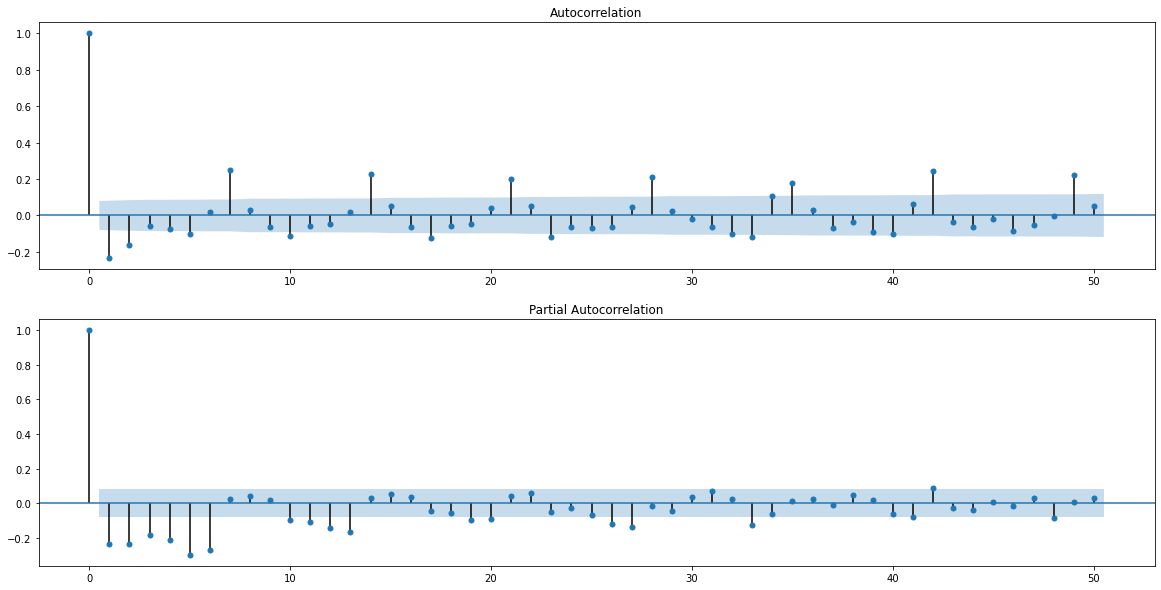

In [4]:
#we use train.diff()(differenced data), because this time series is unit root process.
import statsmodels.api as sm
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 7 periods, indicating a weekly pattern exists; hence p=7.
Since our time series data is stationary, no differencing is needed, so d=0.
Since there's seasonality, we will use Seasonal Moving Average models instead of regular Moving Average models.

# ARIMA Modeling
We will use SARIMAX but with seasonal_order =  all zeros, so it has same result as ARIMA

# Finding best q for ARIMA hyperparameter

# Grid search method for best parameters based on MSE, smape, and AIC
#change from markdown to code to run
# Result for lowest MSE & SMAPE order=(6,0,4) MSE=61589, SMAPE=14.55, AIC=8116
# Result for lowest AIC order=(7,1,7) MSE=81096, SMAPE=17.68, AIC=8023
#create empty lists to store values
p_list = []
d_list = []
q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for p in [6, 7]: #6,7 some people say 6, some say 7
    for d in [0, 1]:
        for q in range(0,8): # originally did 0~10, but we already know when q=4 the model metric had lowest MSE.
            # fit the model
            arima = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),freq='D',seasonal_order=(0,0,0,0),
                                             enforce_stationarity=False, enforce_invertibility=False,).fit()
            # get the prediction
            pred = arima.predict(train_end,test_end)[1:]
            # calculate the MSE and smape
            MSE = mean_squared_error(test,pred)
            SMAPE = smape(test,pred)
            # append the values
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(MSE)
            SMAPE_list.append(SMAPE)
            AIC_list.append(arima.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

score_df = pd.DataFrame.from_dict(score_dict)

display(score_df.loc[score_df['MSE']==score_df.MSE.min()])
display(score_df.loc[score_df['SMAPE']==score_df.SMAPE.min()])
score_df.loc[score_df['AIC']==score_df.AIC.min()]

# Auto_arima to search for best params
#change from markdown to code to run
# Result order=(10,0,0)
auto_arima(train, exogenous=None, 
           start_p=6, d=None, start_q=0, max_p=10, max_d=1, max_q=10, # grid search for order params
           start_P=0, D=None, start_Q=0, max_P=0, max_D=0, max_Q=0, m=0, #grid search for seasonal order params, seaonal=True
           max_order=21, seasonal=False, stationary=True, information_criterion='aic', suppress_warnings=True) 
#maxorder = allowed sum of p and q, since an year has 12 months, so we'll have 11 as max for p, 10 for q
#data already stationary so stationary=True

# ARMA order select to search for best params
#change from markdown to code to run
# Result p=8, q=8, d has to be 0, since it's designed for ARMA
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [5]:
#need to change working directory to data, where the data are saved
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

In [6]:
# create empty lists to save the data
model_list = []
R2_list = []
mean_SE_list = []
mean_AE_list = []
smape_list = []
aic_list = []

In [7]:
# create a function to take in the order parameters for ARIMA, fit, plot diagnostics, display metrics scores,
# plot the test vs predict and save everything
def ARIMA101(p, d, q):
    #fit the model with given params
    arima = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),freq='D',seasonal_order=(0,0,0,0),
                                     enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arima.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arima{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arima.predict(train_end,test_end)[1:]
    #record the metrics and model name
    model_list.append('ARIMA{}'.format(str(p)+str(d)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(arima.aic)
    print('ARIMA{} model R2:'.format(str(p)+str(d)+str(q)), r2_score(test,pred))
    print('ARIMA{} model MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMA{} model MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMA{} model smape:'.format(str(p)+str(d)+str(q)), smape(test,pred))
    print('ARIMA{} model AIC:'.format(str(p)+str(d)+str(q)), arima.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred}).plot()
    plt.suptitle('ARIMA{} test vs prediction'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict"])
    plt.savefig('arima{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


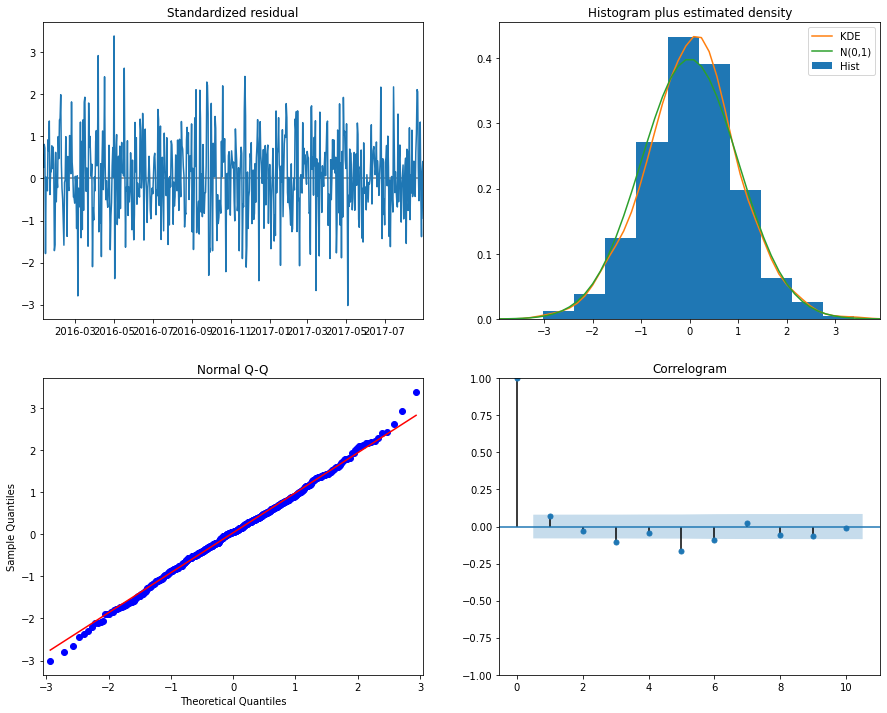

ARIMA604 model R2: 0.20893337185695948
ARIMA604 model MSE: 61589.21412388973
ARIMA604 model MAE: 187.02958546255718
ARIMA604 model smape: 14.548084972410518
ARIMA604 model AIC: 8116.19904528846


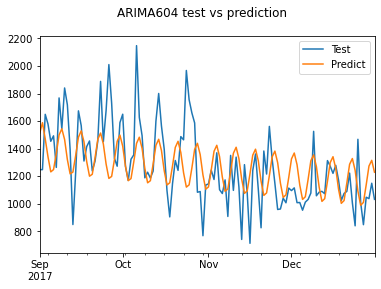

In [8]:
ARIMA101(6,0,4) #lowest MSE & smape from grid search with p=6-7, d=0-1, q=0-8

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the top right plot, we see that the KDE line follows pretty close with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is also an indication that the residuals are normally distributed.

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


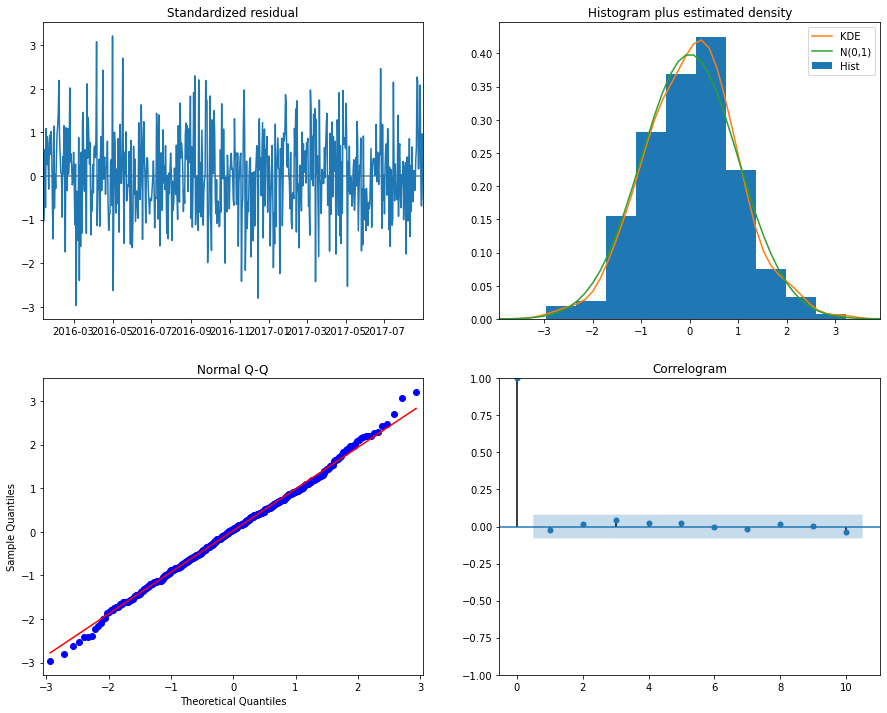

ARIMA717 model R2: -0.04162504693331193
ARIMA717 model MSE: 81096.66843483926
ARIMA717 model MAE: 228.18255441018786
ARIMA717 model smape: 17.68176827349397
ARIMA717 model AIC: 8023.222453838933


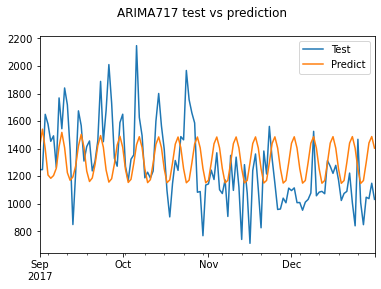

In [9]:
ARIMA101(7,1,7) #lowest AIC from grid search with p=6-7, d=0-1, q=0-8

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


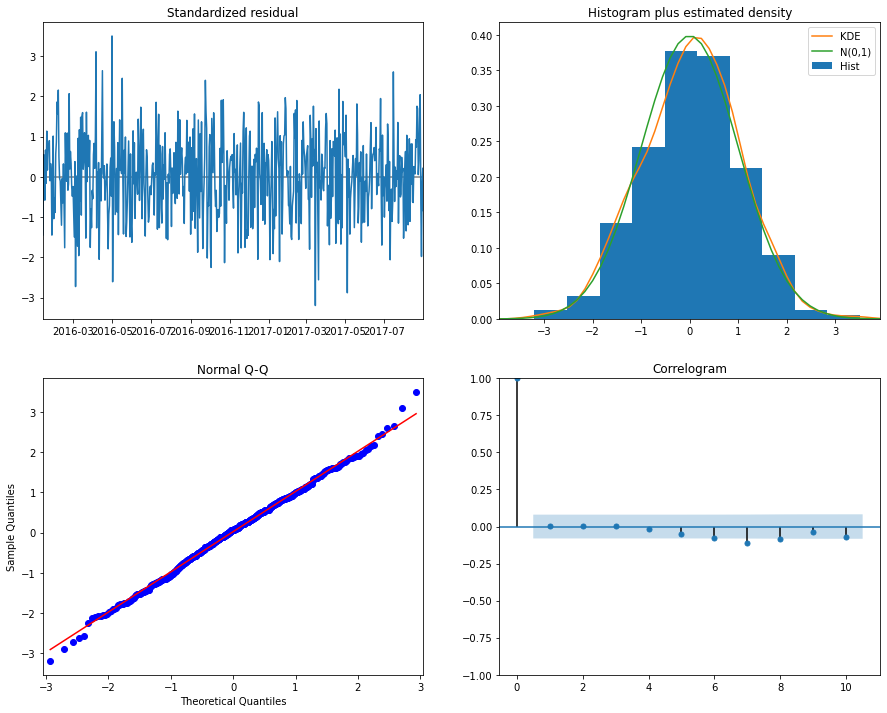

ARIMA1000 model R2: 0.07544580672056544
ARIMA1000 model MSE: 71982.01030511792
ARIMA1000 model MAE: 220.9209885812315
ARIMA1000 model smape: 17.2431523040165
ARIMA1000 model AIC: 8091.192979403077


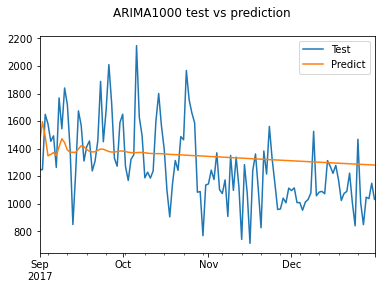

In [10]:
ARIMA101(10,0,0) #best params based on auto_arima

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


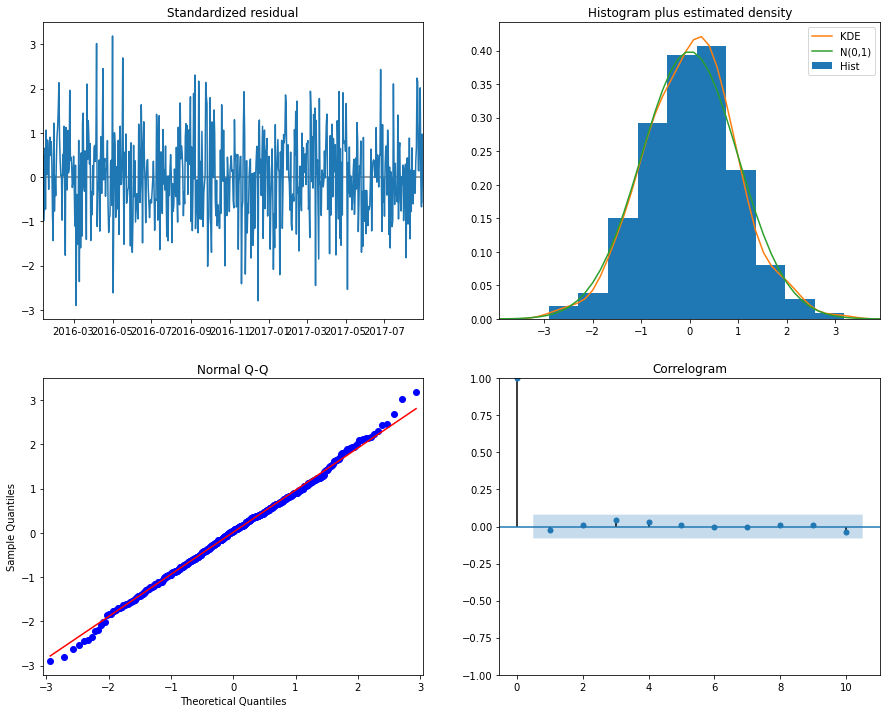

ARIMA808 model R2: -0.11403173120347021
ARIMA808 model MSE: 86733.95690443867
ARIMA808 model MAE: 237.35942596772549
ARIMA808 model smape: 18.342182938851156
ARIMA808 model AIC: 8025.433048296642


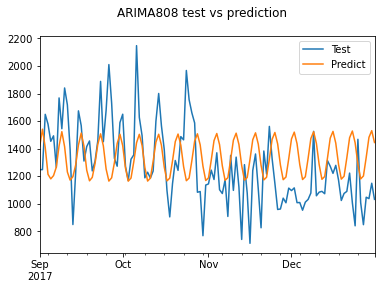

In [11]:
ARIMA101(8,0,8) #best params based on arma order select

# ARIMAX
ARIMA with features

In [12]:
#create another df and add features: month, day of week
buf = df2.copy()
#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)

In [13]:
#re do test and train data with features added
train_start,train_end = '2016-01-04','2017-08-31'
test_start,test_end = '2017-09-01','2017-12-31'
train = df2['Daily'][train_start:train_end].dropna()
test = df2['Daily'][test_start:test_end].dropna()
exog_train = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                  'Mon','Tue','Wed','Thu','Fri','Sat','Sun']][train_start:train_end].dropna()
exog_test = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']][test_start:test_end].dropna()

In [14]:
# create a function like ARIMA101 but for ARIMAX
def ARIMAX101(p, d, q):
    #fit the model with given params
    arimax = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(0,0,0,0),exog=exog_train,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arimax.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arimax{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arimax.predict(train_end,test_end,exog = exog_test)[1:]
    #record the metrics and model name
    model_list.append('ARIMAX{}'.format(str(p)+str(d)+str(q)))
    R2_list.append(r2_score(test,pred))
    mean_SE_list.append(mean_squared_error(test,pred))
    mean_AE_list.append(mean_absolute_error(test,pred))
    smape_list.append(smape(test,pred))
    aic_list.append(arimax.aic)
    print('ARIMAX{} model R2:'.format(str(p)+str(d)+str(q)), r2_score(test,pred))
    print('ARIMAX{} model MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMAX{} model MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMAX{} model smape:'.format(str(p)+str(d)+str(q)), smape(test,pred))
    print('ARIMAX{} model AIC:'.format(str(p)+str(d)+str(q)), arimax.aic)
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred}).plot()
    plt.suptitle('ARIMAX{} test vs prediction'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict"])
    plt.savefig('arimax{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


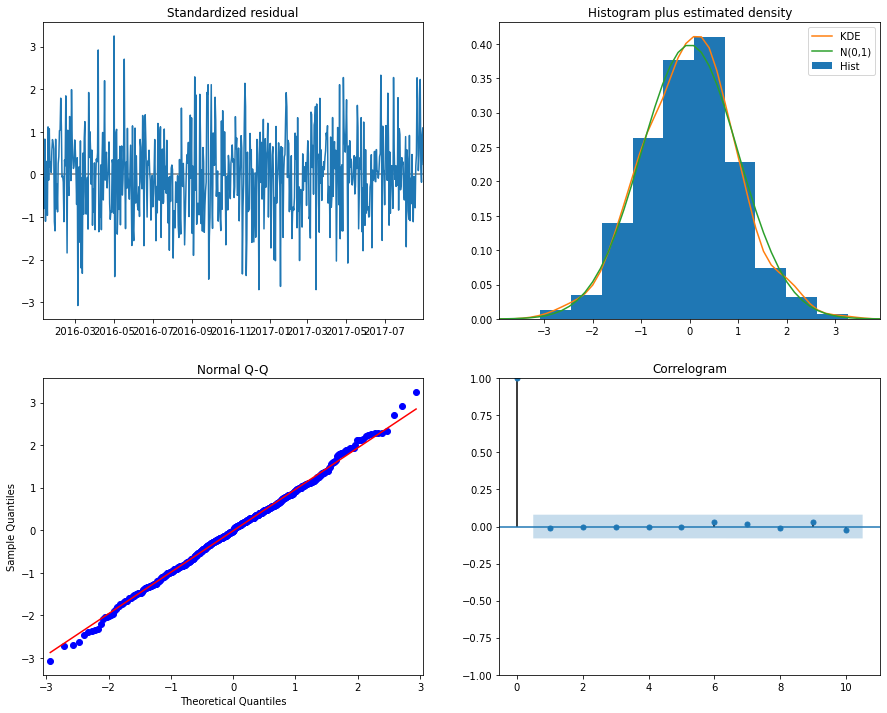

ARIMAX604 model R2: 0.08186070572575332
ARIMAX604 model MSE: 71482.57248994794
ARIMAX604 model MAE: 202.42437188243122
ARIMAX604 model smape: 15.858148141297134
ARIMAX604 model AIC: 8011.718832286065


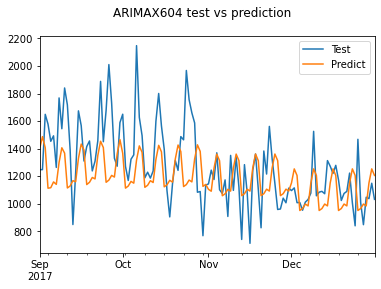

In [15]:
ARIMAX101(6,0,4)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


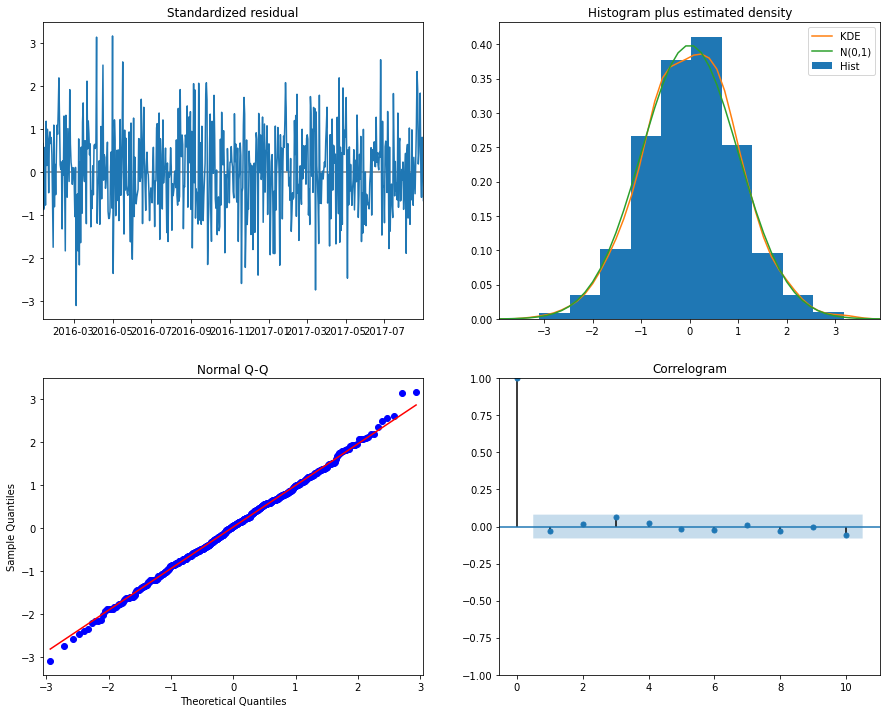

ARIMAX717 model R2: -0.0945286054488117
ARIMAX717 model MSE: 85215.5232536494
ARIMAX717 model MAE: 238.71275646569396
ARIMAX717 model smape: 18.458903552489172
ARIMAX717 model AIC: 8045.563275688385


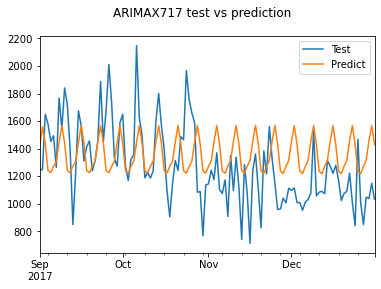

In [17]:
ARIMAX101(7,1,7)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


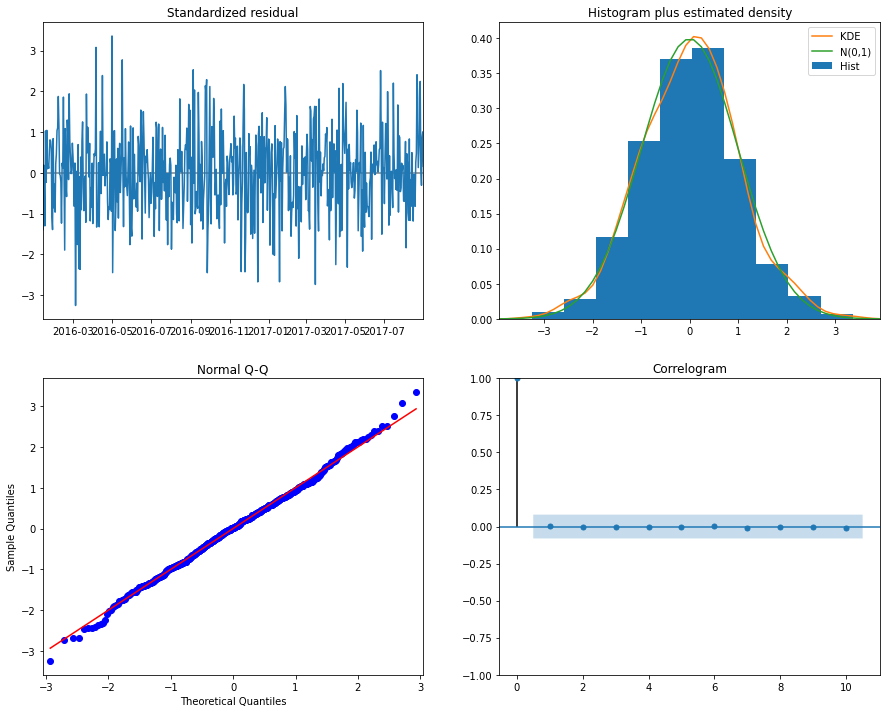

ARIMAX1000 model R2: 0.1406432463925047
ARIMAX1000 model MSE: 66906.00415161555
ARIMAX1000 model MAE: 194.25583431796957
ARIMAX1000 model smape: 15.205076631051128
ARIMAX1000 model AIC: 7964.617621604544


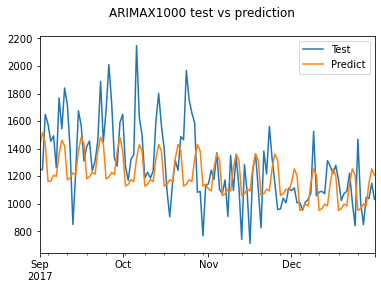

In [18]:
ARIMAX101(10,0,0)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


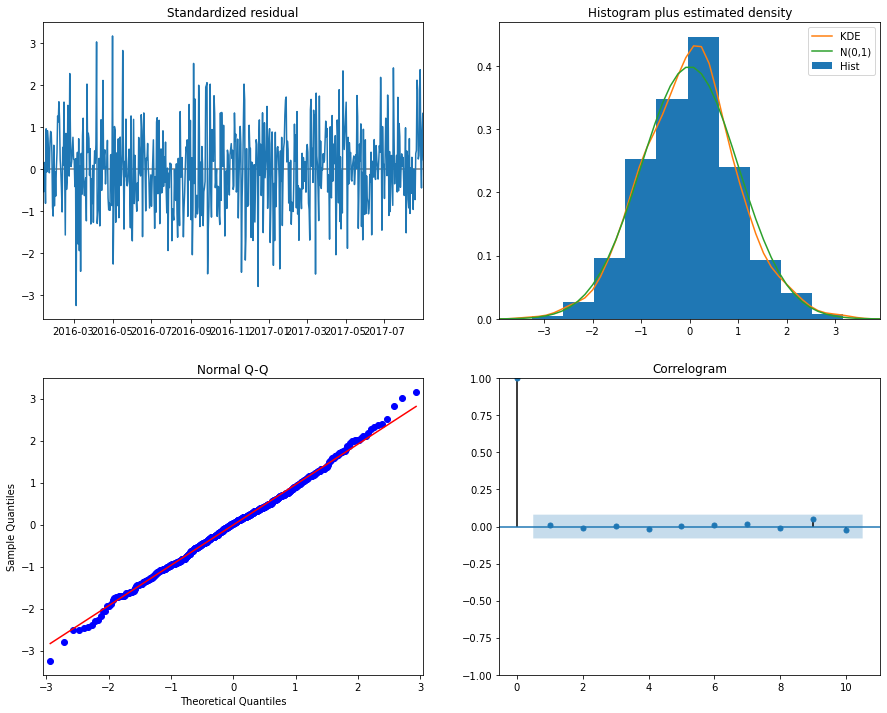

ARIMAX808 model R2: 0.04724319832181789
ARIMAX808 model MSE: 74177.75011479751
ARIMAX808 model MAE: 207.78683263420578
ARIMAX808 model smape: 16.295983666570873
ARIMAX808 model AIC: 7978.096387814972


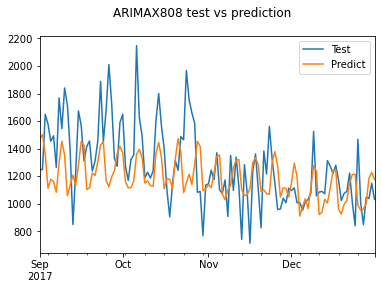

In [19]:
ARIMAX101(8,0,8)

# SARIMAX Model
We will use same orders
We will take a look at ACF and PACF again to determine P, D, Q, and S

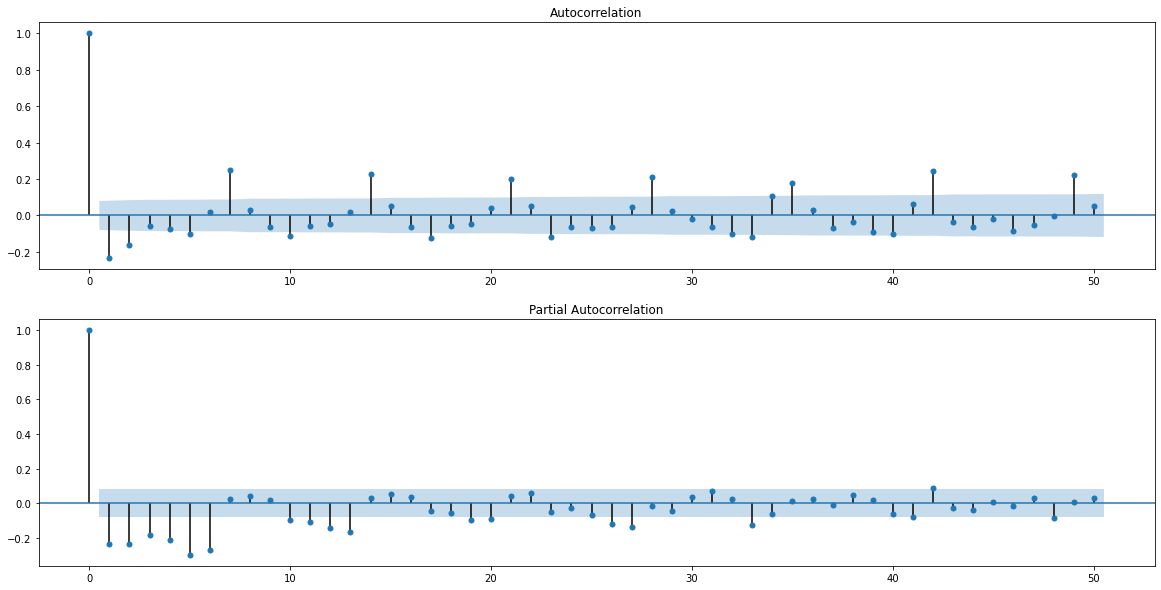

In [28]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

Since there's an obvious periodicity of weekly patter, S=7
The patter continues after 2 lags, so D=1
There's a huge difference between lag6 and lag7, so P is either 6 or 7

In [27]:
# view the current model and its scores
model_score_dict = {
    'model': model_list,
    'R2': R2_list,
    'MSE': mean_SE_list,
    'MAE': mean_AE_list,
    'SMAPE': smape_list,
    'AIC': aic_list,
}
model_score_df = pd.DataFrame.from_dict(model_score_dict)
df = model_score_df.set_index('model')
df

,R2,MSE,MAE,SMAPE,AIC
model,,,,,
ARIMA604,0.208933,61589.214124,187.029585,14.548085,8116.199045
ARIMA717,-0.041625,81096.668435,228.182554,17.681768,8023.222454
ARIMA1000,0.075446,71982.010305,220.920989,17.243152,8091.192979
ARIMA808,-0.114032,86733.956904,237.359426,18.342183,8025.433048
ARIMAX604,0.081861,71482.572490,202.424372,15.858148,8011.718832
ARIMAX717,-0.094529,85215.523254,238.712756,18.458904,8045.563276
ARIMAX1000,0.140643,66906.004152,194.255834,15.205077,7964.617622
ARIMAX808,0.047243,74177.750115,207.786833,16.295984,7978.096388


From ARIMAX models, we can see that params 717 has the worst over all scores, with the only params with negative R2, highest MSE, MAE, SMAPE, and AIC. If we're to take a look at its predictions, it's also horrible. So we will not be using those params for SARIMAX modeling.

In [47]:
# grid search for P and Q with order604
P_list = []
Q_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for P in [11,12]:
        for Q in range(0,6):
            # fit the model
            sarimax = sm.tsa.statespace.SARIMAX(train,order=(6,0,4),seasonal_order=(P,1,Q,7),exog = exog_train, 
                                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
            # get the prediction
            pred = sarimax.predict(train_end,test_end,exog = exog_test)[1:]
            # calculate the MSE and smape
            MSE = mean_squared_error(test,pred)
            SMAPE = smape(test,pred)
            # append the values
            P_list.append(P)
            Q_list.append(Q)
            MSE_list.append(MSE)
            SMAPE_list.append(SMAPE)
            AIC_list.append(sarimax.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
score_dict = {
    'P': P_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

score_df = pd.DataFrame.from_dict(score_dict)

display(score_df.loc[score_df['MSE']==score_df.MSE.min()])
display(score_df.loc[score_df['SMAPE']==score_df.SMAPE.min()])
score_df.loc[score_df['AIC']==score_df.AIC.min()]

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency informat

KeyboardInterrupt: 

Result of above cell: (P,Q) MSE, smape, AIC

(6,1) 78150, 17.04, 7494

(7,5) 78322, 16.97, 7407

(7,0) 89800, 18.45, 7402

In [49]:
# grid search for P and Q with order604
P_list = []
MSE_list = []
SMAPE_list = []
AIC_list = []
#iternation
for P in [8,10]:
            # fit the model
            sarimax = sm.tsa.statespace.SARIMAX(train,order=(6,0,4),seasonal_order=(P,1,0,7),exog = exog_train, 
                                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
            # get the prediction
            pred = sarimax.predict(train_end,test_end,exog = exog_test)[1:]
            # calculate the MSE and smape
            MSE = mean_squared_error(test,pred)
            SMAPE = smape(test,pred)
            # append the values
            P_list.append(P)
            MSE_list.append(MSE)
            SMAPE_list.append(SMAPE)
            AIC_list.append(sarimax.aic)

#create a dict to store the key:values then change to dataframe for easier/cleaner access
score_dict = {
    'P': P_list,
    'MSE': MSE_list,
    'SMAPE': SMAPE_list,
    'AIC': AIC_list,
}

score_df = pd.DataFrame.from_dict(score_dict)
display(score_df.loc[score_df['MSE']==score_df.MSE.min()])
display(score_df.loc[score_df['SMAPE']==score_df.SMAPE.min()])
score_df.loc[score_df['AIC']==score_df.AIC.min()]

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


KeyboardInterrupt: 

In [ ]:
# fit
sarimax = sm.tsa.statespace.SARIMAX(train,order=(6,0,4),seasonal_order=(11,0,4,1),exog = exog_train,
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarimax.summary()

In [ ]:
#get the diagnostics for the model
sarimax.plot_diagnostics(figsize=(15, 12))
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures\\sarimax_diagnostics.png')
plt.show()

The result came up to be
P=11 Q=4

In [ ]:
#Metrics; calculate the R-squared, MSE, MAE
pred = sarimax.predict(train_end,test_end,exog = exog_test)[1:]
# record the scores
model_list.append('SARIMAX')
R2_list.append(r2_score(test,pred))
mean_SE_list.append(mean_squared_error(test,pred))
mean_AE_list.append(mean_absolute_error(test,pred))
smape_list.append(smape(test,pred))
print('SARIMAX model R2:{}'.format(r2_score(test,pred)))
print('SARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))
print('SARIMAX model MAE:{}'.format(mean_absolute_error(test,pred)))
print('SARIMAX model smape:{}'.format(smape(test,pred)))

In [ ]:
plt.plot(pd.DataFrame({'test':test,'pred':pred}))
plt.title('SARIMAX test vs prediction')
plt.legend(["Test", "Predict"]) 
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures\\sarimax_test_pred.png')
plt.show()

Surprisingly, after introducing the month and day of week features, the models with such features have worse score. It is very obvious if we are to compare the models by their R squared. ARIMA has the best models scores from the other two. However, since we had d=0 in the order parameter, it is actually the same as ARMA model.

In [ ]:
# view the model and its test vs pred 
arima_pred = arima.predict(train_end,test_end)[1:]
arimax_pred = arimax.predict(train_end,test_end,exog = exog_test)[1:]
sarimax_pred = sarimax.predict(train_end,test_end,exog = exog_test)[1:]
pd.DataFrame({'True':test,'arima':arima_pred,'arimax':arimax_pred,'sarimax':sarimax_pred}).plot()
plt.suptitle('True vs Predictions')
plt.legend(["Test", "Arima","Arimax","Sarimax"]) 
plt.show()

The predictions are very close to each other, but we can see that Arimax has more zigzag than the other two models, indicating stronger periodicity pattern (day of week's influence). We will take a closer look at Arima vs Arimax.

In [ ]:
from IPython.display import Image
Image('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures\\arima_test_pred.png') 